In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, ensure_dir, MPIICOOKING2_DIR
import urllib.request

In [32]:
import matplotlib.pyplot as plt

In [3]:
import h5py
import numpy as np

In [4]:
MPIICOOKING2_ANNO = MPIICOOKING2_DIR / "attributesAnnotations_MPII-Cooking-2.mat"

In [5]:
MPIICOOKING2_ANNO.as_posix()

'/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/data/raw/MPIICOOKING2_Data_Dir/attributesAnnotations_MPII-Cooking-2.mat'

In [6]:
f = h5py.File(MPIICOOKING2_ANNO.as_posix(), 'r')

In [7]:
group = f['annos']
group

<HDF5 group "/annos" (37 members)>

In [8]:
for key in group.keys():
    print(key)

activity
annoFileMap
attrFields
attributeMap
bgClassName
bgLabel
bgLabelAttr
classMap
className
containers
containersDestination
containersProperties
containersSource
dataset
dish
endFrame
endTimeSeconds
fields
fileId
fileName
fileNameId
filters
frameRate
iaMat
idxInFile
ingredients
ingredientsProperties
labels
minBgWindow
nImgsPerFile
nullAttr
nullAttrLabel
startFrame
startTimeSeconds
subject
tool
toolProperties


In [9]:
file_ids = group["fileId"].value
file_ids = np.concatenate(file_ids)

In [10]:
np.unique(file_ids)[:5]

array([1., 2., 3., 4., 5.])

In [11]:
activity = group["activity"].value

In [12]:
def reference_to_str(ref, f):
    obj = f[ref]
    return ''.join(chr(i) for i in obj[:])

In [13]:
reference_to_str(activity[0][0], f)

'enterV'

In [14]:
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [22]:
activity = np.array([reference_to_str(i[0],f) for i in tqdm(group["activity"].value)])

In [23]:
len(activity), len(np.unique(activity))

(14105, 87)

In [98]:
np.unique(activity)

array(['addV', 'apply plasterV', 'arrangeV', 'assembleV',
       'change temperatureV', 'chopV', 'cleanV', 'closeV', 'cut apartV',
       'cut diceV', 'cut off endsV', 'cut out insideV', 'cut stripesV',
       'cutV', 'dryV', 'enterV', 'fillV', 'flipV', 'foldV', 'gatherV',
       'grateV', 'grindV', 'hangV', 'lockV', 'mixV', 'moveV', 'open capV',
       'open closeV', 'open eggV', 'open tinV', 'openV', 'packageV',
       'peelV', 'plugV', 'pokeV', 'pourV', 'pressV', 'pull apartV',
       'pull upV', 'pullV', 'pureeV', 'purgeV', 'push downV', 'put inV',
       'put lidV', 'put onV', 'put rubber bandV', 'readV',
       'remove from packageV', 'remove labelV', 'remove rubber bandV',
       'rip offV', 'rip openV', 'rip-offV', 'rollV', 'scratch offV',
       'screw closeV', 'screw openV', 'shakeV', 'shapeV', 'sharpenV',
       'sliceV', 'smellV', 'spiceV', 'spreadV', 'squashV', 'squeezeV',
       'stampV', 'stirV', 'strewV', 'take apartV', 'take lidV',
       'take outV', 'tapV', 'tasteV',

In [74]:
activity_grouped = [activity[file_ids == fid] for fid in np.unique(file_ids)]

In [97]:
len(activity_grouped)

273

In [75]:
activity_lens = [len(i) for i in activity_grouped]

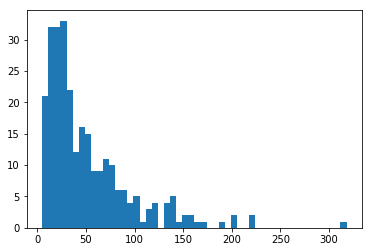

In [76]:
plt.hist(activity_lens, bins = 50);

### Mutual information

In [77]:
from childes_mi.information_theory import mutual_information as mi

In [85]:
activity_indv = [["{}_{}".format(bi, element) for element in bout] for bi, bout in enumerate(tqdm(activity_grouped))]

In [86]:
distances = np.arange(1,100)

In [99]:
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    activity_indv, distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s


[Parallel(n_jobs=-1)]: Done  72 out of  99 | elapsed:    3.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  92 out of  99 | elapsed:    3.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s


[Parallel(n_jobs=-1)]: Done  72 out of  99 | elapsed:    4.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  92 out of  99 | elapsed:    4.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    4.0s finished


In [100]:
import pandas as pd

In [101]:
MI_DF = pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
)

In [102]:
row = MI_DF.iloc[0]

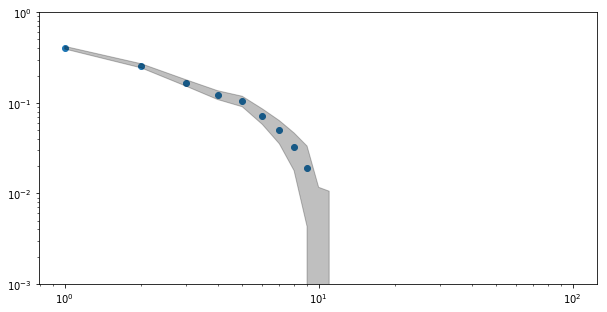

In [103]:
fig, ax = plt.subplots(figsize=(10,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_ylim([1e-3, 1])
ax.set_yscale('log')
ax.set_xscale('log')

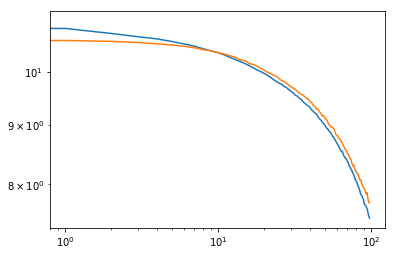

In [104]:
plt.loglog(row.MI)
plt.loglog(row.shuff_MI)